## Multitemporal RGB composite 2017

### Import the Python packages

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import sys
import glob
os.environ['_CIOP_APPLICATION_PATH']=''
sys.path.append('/opt/anaconda/bin/')
import cioppy
ciop = cioppy.Cioppy()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap

import gc

from shapely.wkt import loads 
from shapely.geometry import box
from shapely.geometry import Point
from shapely import geometry

import osr
import ogr

import gdal
from geopandas import GeoDataFrame
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import ellip_snap_helpers

from PIL import Image

%load_ext autoreload
%autoreload 2

### Search parameters

Set the catalogue endpoint to Sentinel-1:

In [2]:
series = 'https://catalog.terradue.com/sentinel1/search'

Define the time of interest:

In [3]:
tois = {'winter': { 'start_date': '2017-01-01T00:00:00', 'stop_date': '2017-01-31T23:59:59' },
        'mid_summer': { 'start_date': '2017-07-01T00:00:00', 'stop_date': '2017-07-31T23:59:59' },
        'late_summer': { 'start_date': '2017-08-15T00:00:00', 'stop_date': '2017-08-31T23:59:59' }}

In [4]:
for index, toi in enumerate(tois):
    
    print toi, tois[toi]['start_date'], tois[toi]['stop_date']

mid_summer 2017-07-01T00:00:00 2017-07-31T23:59:59
late_summer 2017-08-15T00:00:00 2017-08-31T23:59:59
winter 2017-01-01T00:00:00 2017-01-31T23:59:59


Define the area of interest:

In [5]:
def extend_aoi(center_x, center_y, extent):
    
    polar_epsg = 3575 # 3995
    latlon_epsg = 4326
    
    center_polar = loads(convert_coords(latlon_epsg, polar_epsg, Point(center_x, center_y).wkt))
    
    ll = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [6]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [7]:
poi = loads('POINT (-35.3 83.90000000000001)')

In [8]:
extended_aoi = extend_aoi(poi.x, poi.y, 50000)

extended_aoi

'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'

### Build and submit the catalog search


In [9]:
results = []

for index, toi in enumerate(tois):
    
    print toi
    
    search_params = dict([('geom', extended_aoi),
                          ('start', tois[toi]['start_date']),
                          ('stop', tois[toi]['stop_date']),
                          ('track', '74'),
                          ('pt', 'GRD'),
                          ('psn', 'S1A'),
                          ('do', 'terradue'),
                          ('count', 1)])
    
    print search_params

    search = ciop.search(end_point = series,
                     params = search_params,
                     output_fields='self,enclosure,identifier,startdate,wkt', 
                     model='GeoTime')
    
    print search[0]['identifier']    
    results.append(search[0])

results = GeoDataFrame(results)

mid_summer
{'count': 1, 'do': 'terradue', 'psn': 'S1A', 'pt': 'GRD', 'track': '74', 'stop': '2017-07-31T23:59:59', 'start': '2017-07-01T00:00:00', 'geom': 'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'}
S1A_IW_GRDH_1SDH_20170726T183119_20170726T183146_017646_01D89E_770E
late_summer
{'count': 1, 'do': 'terradue', 'psn': 'S1A', 'pt': 'GRD', 'track': '74', 'stop': '2017-08-31T23:59:59', 'start': '2017-08-15T00:00:00', 'geom': 'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'}
S1A_IW_GRDH_1SDH_20170831T183121_20170831T183148_018171_01E882_C807
winter
{'count': 1, 'do': 'terradue', 'psn': 'S1A', 'pt': 'GRD', 'track': '74', 'stop': '2017-01-31T23:59:59', 'start': '2017-01-01T00:00:00', 'geom': 'POLYGON ((-35

In [10]:
results

,enclosure,identifier,self,startdate,wkt
0,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170726T183119_20170726T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-07-26T18:31:19.4376280Z,"POLYGON((-52.293312 83.079704,-35.494884 84.46..."
1,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170831T183121_20170831T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-08-31T18:31:21.1632340Z,"POLYGON((-52.299252 83.08004,-35.500076 84.465..."
2,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SSH_20170127T183112_20170127T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-01-27T18:31:12.9617610Z,"POLYGON((-52.302452 83.079826,-35.50042 84.465..."


In [11]:
results['startdate'] = pd.to_datetime(results['startdate']) 
results['wkt'] = results['wkt'].apply(loads)

In [12]:
results

,enclosure,identifier,self,startdate,wkt
0,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170726T183119_20170726T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-07-26 18:31:19.437628,"POLYGON ((-52.293312 83.07970400000001, -35.49..."
1,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170831T183121_20170831T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-08-31 18:31:21.163234,"POLYGON ((-52.299252 83.08004, -35.500076 84.4..."
2,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SSH_20170127T183112_20170127T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-01-27 18:31:12.961761,"POLYGON ((-52.302452 83.079826, -35.50042 84.4..."


In [13]:
def analyse(row, aoi_wkt):

    aoi = loads(aoi_wkt)

    aoi_intersection = (row['wkt'].intersection(aoi).area / aoi.area) * 100
        
    series = dict([('aoi_intersection', aoi_intersection)])
    
    return pd.Series(series)

In [14]:
results = results.merge(results.apply(lambda row: analyse(row, extended_aoi), axis=1), 
              left_index=True,
              right_index=True)

In [15]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection
0,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170726T183119_20170726T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-07-26 18:31:19.437628,"POLYGON ((-52.293312 83.07970400000001, -35.49...",76.643189
1,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170831T183121_20170831T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-08-31 18:31:21.163234,"POLYGON ((-52.299252 83.08004, -35.500076 84.4...",76.637180
2,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SSH_20170127T183112_20170127T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-01-27 18:31:12.961761,"POLYGON ((-52.302452 83.079826, -35.50042 84.4...",76.640081


In [16]:
results['identifier'].values

array(['S1A_IW_GRDH_1SDH_20170726T183119_20170726T183146_017646_01D89E_770E',
       'S1A_IW_GRDH_1SDH_20170831T183121_20170831T183148_018171_01E882_C807',
       'S1A_IW_GRDH_1SSH_20170127T183112_20170127T183139_015021_01889A_ACBF'], dtype=object)

In [17]:
target_dir = '/workspace/data2'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

def stage_in(row):
    
    local_path = ciop.copy(row['enclosure'], extract=False, target=target_dir)
    row['local_path'] = local_path
        
    return row 
    

In [18]:
results = results.apply(lambda row: stage_in(row), axis=1)

In [19]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection,local_path
0,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170726T183119_20170726T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-07-26 18:31:19.437628,"POLYGON ((-52.293312 83.07970400000001, -35.49...",76.643189,/workspace/data2/S1A_IW_GRDH_1SDH_20170726T183...
1,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170831T183121_20170831T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-08-31 18:31:21.163234,"POLYGON ((-52.299252 83.08004, -35.500076 84.4...",76.637180,/workspace/data2/S1A_IW_GRDH_1SDH_20170831T183...
2,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SSH_20170127T183112_20170127T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-01-27 18:31:12.961761,"POLYGON ((-52.302452 83.079826, -35.50042 84.4...",76.640081,/workspace/data2/S1A_IW_GRDH_1SSH_20170127T183...


### Process sigma0

In [20]:
def sigma0(row, aoi):
    
    local_path = row['local_path']
    identifier = row['identifier']
    
    mygraph = ellip_snap_helpers.GraphProcessor()
    
    operator = 'Read'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['file'] = local_path 
    mygraph.add_node(operator,
                     operator, 
                     parameters,
                     '') 
    
    operator = 'ThermalNoiseRemoval'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Read')
    

    operator = 'Apply-Orbit-File'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator, 
                     operator, 
                     parameters, 
                     'ThermalNoiseRemoval')



    operator = 'Calibration'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters, 
                     'Apply-Orbit-File')


    operator = 'Speckle-Filter'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator, 
                     operator,
                     parameters, 
                     'Calibration')


    operator = 'Multilook'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Speckle-Filter')


    operator = 'LinearToFromdB'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Multilook')


    operator = 'Terrain-Correction'

    map_proj = """PROJCS["WGS 84 / North Pole LAEA Europe",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",90],
    PARAMETER["longitude_of_center",10],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["X",EAST],
    AXIS["Y",NORTH],
    AUTHORITY["EPSG","3575"]]"""

    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['demName'] = 'ACE30'  
    parameters['saveDEM'] = 'true'
    parameters['mapProjection'] = map_proj
    parameters['nodataValueAtSea'] = 'false'   
                

    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'LinearToFromdB')

    operator = 'Subset'
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['geoRegion'] = aoi 

    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Terrain-Correction')


    operator = 'Write'
    
    output_name = 'SIGMA0_%s' % identifier
    
    parameters = ellip_snap_helpers.get_operator_default_parameters(operator)
    parameters['file'] = output_name
    parameters['formatName'] = 'GeoTIFF-BigTiff'
    mygraph.add_node(operator,
                     operator,
                     parameters,
                     'Subset')

    mygraph.run()
    
    row['sigma0'] = output_name + '.tif'
    
    return row

In [21]:
results = results.apply(lambda row: sigma0(row, extended_aoi), axis=1)

Processing the graph
Process PID: 18760
Executing processing graph
....10%....20%....30%....40%....50%....60%....70%....80%....90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.hsqldb.persist.Logger: dataFileCache open start

Done.
Processing the graph
Process PID: 18838
Executing processing graph
....10%....20%....30%....40%....50%....60%....70%....80%....90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.engine_utilities.download.downloadablecontent.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/orbits/Sentinel-1/POEORB/S1A/2017/08/S1A_OPER_AUX_POEORB_OPOD_20170920T121943_V20170830T225942_20170901T005942.EOF.zip

Done.
Processing the graph
Process PID: 18917
Executing processing graph
....10%....20%....30%....40%....50%....60%....70%....80%....90% done.
INFO

In [22]:
results

,enclosure,identifier,self,startdate,wkt,aoi_intersection,local_path,sigma0
0,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170726T183119_20170726T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-07-26 18:31:19.437628,"POLYGON ((-52.293312 83.07970400000001, -35.49...",76.643189,/workspace/data2/S1A_IW_GRDH_1SDH_20170726T183...,SIGMA0_S1A_IW_GRDH_1SDH_20170726T183119_201707...
1,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SDH_20170831T183121_20170831T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-08-31 18:31:21.163234,"POLYGON ((-52.299252 83.08004, -35.500076 84.4...",76.637180,/workspace/data2/S1A_IW_GRDH_1SDH_20170831T183...,SIGMA0_S1A_IW_GRDH_1SDH_20170831T183121_201708...
2,https://store.terradue.com/download/sentinel1/...,S1A_IW_GRDH_1SSH_20170127T183112_20170127T1831...,https://catalog.terradue.com/sentinel1/search?...,2017-01-27 18:31:12.961761,"POLYGON ((-52.302452 83.079826, -35.50042 84.4...",76.640081,/workspace/data2/S1A_IW_GRDH_1SSH_20170127T183...,SIGMA0_S1A_IW_GRDH_1SSH_20170127T183112_201701...


In [23]:
sigma0s = list(results['sigma0'].values)

In [24]:
sigma0s

['SIGMA0_S1A_IW_GRDH_1SDH_20170726T183119_20170726T183146_017646_01D89E_770E.tif',
 'SIGMA0_S1A_IW_GRDH_1SDH_20170831T183121_20170831T183148_018171_01E882_C807.tif',
 'SIGMA0_S1A_IW_GRDH_1SSH_20170127T183112_20170127T183139_015021_01889A_ACBF.tif']

In [25]:
ds = gdal.Open(sigma0s[0])

geo_transform = ds.GetGeoTransform()
proj = ds.GetProjection()

srs=osr.SpatialReference(wkt=proj)

w = ds.GetRasterBand(1).XSize
h = ds.GetRasterBand(1).YSize

ds = None

In [26]:
bands = []

min_db = -26
max_db = 6

rgb_name = 'multitemporal_rgb_2016' + '.tif'
    
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF']
    
dst_ds = gdal.GetDriverByName('GTiff').Create(rgb_name, w, h, 3, gdal.GDT_Byte, options=options)
    
dst_ds.SetGeoTransform(geo_transform)   
 
dst_ds.SetProjection(srs.ExportToWkt()) 

for index, tif in enumerate(sigma0s):
    
    raster = gdal.Open(tif)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray(0, 0, w, h)
    
    band_dest = (array * 255 / (max_db - min_db))
    
    bands.append(band_dest)
    
    dst_ds.GetRasterBand(index + 1).WriteArray(band_dest.astype(np.uint8))
    
dst_ds.FlushCache()                    
dst_ds = None

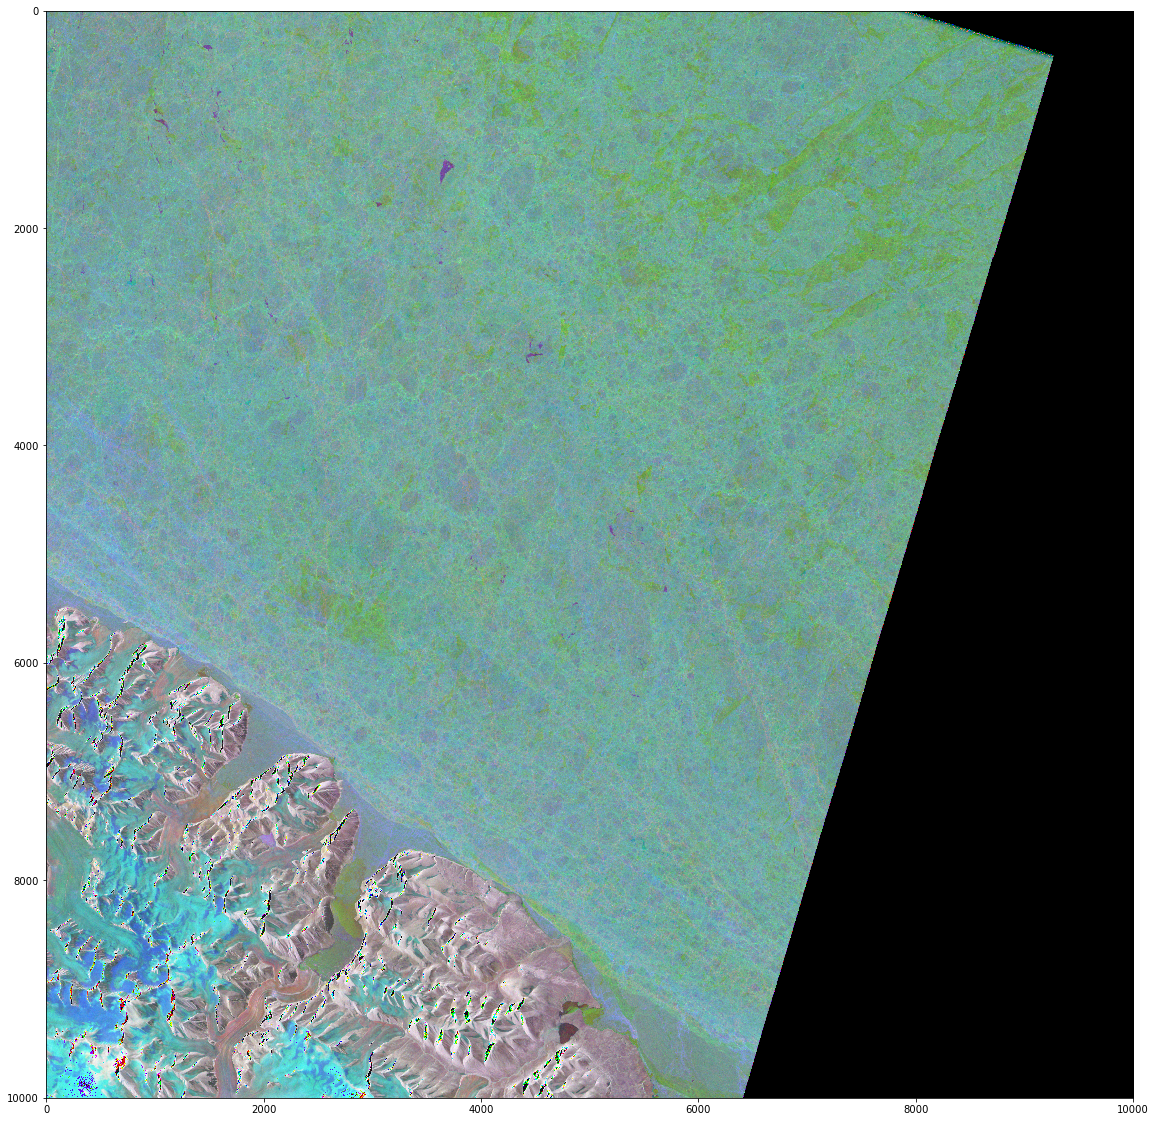

In [27]:
rgb_uint8 = np.dstack(bands).astype(np.uint8) 

width = 20
height = 20
plt.figure(figsize=(width, height))
img = Image.fromarray(rgb_uint8)
imgplot = plt.imshow(img)